In [1]:
import os
from functools import partial

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.contrib.slim as slim

from scipy.stats import poisson, norm

We change define the leaky_relu with default parameter `alpha=0.1`

In [2]:
leaky_relu = partial(tf.nn.leaky_relu,alpha=0.1)

Define parameters of the model.

In [3]:
batch_size = 64
learning_rate = 0.01
lambda_gradient = 0.05 # Gradient penalty
lambda_entropy = 5. # Entropy penalty
obs_poisson_rate = 7. # Poisson rate of the observed data
prop_initial_mu = np.log(5) # Initial mu of the proposal distribution 
prop_initial_log_sigma = np.log(0.3) # Inintial log(sigma) of the proposal distribution
beta1 = 0.5
beta2 = 0.5
critic_steps = 100
count_steps = 300+1

#For reproducibility 
tf.set_random_seed(2210)
np.random.seed(2210)

Generate observed samples and define simulator.

In [4]:
# Generate observed samples
obs_samples = poisson.rvs(obs_poisson_rate,size=20000)

# Define simulator
def simulator(X,epsilon=1e-7):
    return poisson.rvs(np.exp(X))+epsilon

Define AVO model.

In [5]:
batch_shape = (batch_size, 1)
critic_shape = (batch_size, 1)

# Placeholder for real distribution
X_real = tf.placeholder(tf.float32,shape=batch_shape)

# Define proposal parameters Psi
with tf.variable_scope('proposal'):
    mu = tf.get_variable('mu', shape=(), initializer=tf.constant_initializer(prop_initial_mu))
    # We use logarithm of sigma since sigma >= 0 in order to stretch it over the real line
    lg_sigma = tf.get_variable('lg_sigma', shape=(), initializer=tf.constant_initializer(prop_initial_log_sigma))

# Define proposal distribution q
prop_distribution = tf.contrib.distributions.Normal(loc=mu, scale=tf.exp(lg_sigma))
sample_proposal = tf.stop_gradient(prop_distribution.sample(sample_shape=batch_shape))

# Compute the log probability for the parameters 
log_prob_prop = prop_distribution.log_prob(sample_proposal)
#Analytic differential entropy for the proposal distribution
entropy_proposal = lg_sigma 

# Placeholder for simulated distribution
X_sim = tf.placeholder(tf.float32,shape=batch_shape)

# Define the critic
def critic(x):
    layer = slim.stack(x, slim.fully_connected, [10, 10], scope='shared', activation_fn=leaky_relu)
    logits = slim.fully_connected(layer, 1, activation_fn=tf.identity, scope='logits')
    return logits

# Define interpolated data points for the Gradient Penalty Term
eps = tf.random_uniform(critic_shape, minval=0., maxval=1.)
X_interp = eps*X_real + (1.-eps)*X_sim

# Compute critic for different inputs sharing the same variables of the NN:
with tf.variable_scope('critic'):
    critic_real = critic(X_real)
    tf.get_variable_scope().reuse_variables()
    critic_sim = critic(X_sim)
    critic_interp = critic(X_interp)

# Gradient penalty 
grad = tf.gradients(critic_interp, [X_interp])[0]
gradient_penalty = lambda_gradient * tf.square(tf.norm(grad, 2,axis=1) - 1)

# Define losses
loss_critic = tf.reduce_mean(critic_sim - critic_real + gradient_penalty)
wgan_loss = -tf.reduce_mean(critic_sim - critic_real) # Distance between distributions
loss_prop = tf.reduce_mean(-tf.multiply(critic_sim, log_prob_prop) + lambda_entropy*entropy_proposal)

# Define trainable variables
prop_vars = [var for var in tf.trainable_variables() if var.name.startswith('proposal')]
critic_vars = [var for var in tf.trainable_variables() if var.name.startswith('critic')]

# Define optimizers
critic_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='critic', beta1=beta1, beta2=beta2)
prop_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='proposal', beta1=beta1, beta2=beta2)

# Define training operations
train_critic = critic_optimizer.minimize(loss_critic, var_list=critic_vars)
train_proposal = prop_optimizer.minimize(loss_prop, var_list=prop_vars)

# Define variables to reset for critic optimizer
velocity_vars = [critic_optimizer.get_slot(var, 'v') for var in critic_vars]
momentum_vars = [critic_optimizer.get_slot(var, 'm') for var in critic_vars]
reset_vel_mom = tf.variables_initializer(velocity_vars + momentum_vars)

#Reset beta power variables:
reset_b1 = tf.assign(critic_optimizer._beta1_power,beta1)
reset_b2 = tf.assign(critic_optimizer._beta2_power,beta2)
reset_critic = [reset_b1,reset_b2,reset_vel_mom]

Run AVO model to find the parameter distribution.

In [6]:
# Save losses
wgan_losses = np.zeros(count_steps)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    # Output the current values
    mu_val, lg_sigma_val = sess.run([mu, lg_sigma])
    print('Step 0: mu = {}, sigma = {}'.format(mu_val, np.exp(lg_sigma_val)))

    for epoch in range(count_steps):
        # Reset critic optimizer parameters at each epoch
        sess.run(reset_critic)

        # Optimize critic
        for idx in range(critic_steps):
            x_real = np.random.choice(obs_samples,[batch_size,1])
            thetas = sess.run(sample_proposal)
            x_sim = simulator(thetas)
            _, this_loss = sess.run([train_critic, wgan_loss],feed_dict={X_real:x_real,X_sim:x_sim})
        # Save loss after optimizing
        wgan_losses[epoch] = this_loss

        # Update the proposal
        thetas = sess.run(sample_proposal)
        x_sim = simulator(thetas)
        _ = sess.run(train_proposal,feed_dict={X_sim:x_sim,sample_proposal:thetas})

        # Output the current values
        if ((epoch+1) % 10)  == 0:
            mu_val, lg_sigma_val = sess.run([mu, lg_sigma])
            print('Step {}: mu = {}, sigma = {}, em = {}'.format(epoch+1, mu_val, 
                                                                 np.exp(lg_sigma_val), this_loss))
            
    # Save final values of distribution
    mu_val,lg_sigma_val = sess.run([mu, lg_sigma])

Step 0: mu = 1.6094379425048828, sigma = 0.29999998211860657
Step 10: mu = 1.7073651552200317, sigma = 0.3077947199344635, em = 21.79434585571289
Step 20: mu = 1.797516942024231, sigma = 0.3173319399356842, em = 5.831878662109375
Step 30: mu = 1.87786066532135, sigma = 0.3068922162055969, em = 0.5960229635238647
Step 40: mu = 1.8758362531661987, sigma = 0.2809939384460449, em = 3.1009020805358887
Step 50: mu = 1.8789273500442505, sigma = 0.26386597752571106, em = 5.094919681549072
Step 60: mu = 1.8813620805740356, sigma = 0.2476509064435959, em = 2.3606066703796387
Step 70: mu = 1.9117578268051147, sigma = 0.23282122611999512, em = 2.9583635330200195
Step 80: mu = 1.9088040590286255, sigma = 0.2245437055826187, em = 2.7919392585754395
Step 90: mu = 1.9075984954833984, sigma = 0.2058238685131073, em = 2.942840337753296
Step 100: mu = 1.9340057373046875, sigma = 0.18983188271522522, em = 2.908395528793335
Step 110: mu = 1.9198776483535767, sigma = 0.17438092827796936, em = 0.505717933177

Plot result:

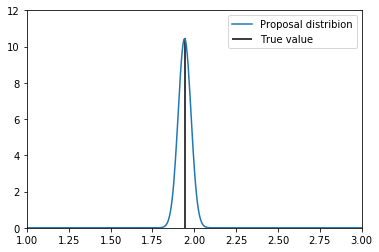

In [7]:
x = np.linspace(1,3,400)
y = norm.pdf(x,mu_val,np.exp(lg_sigma_val))

plt.plot(x,y,label="Proposal distribion")
plt.vlines(np.log(7),0,y.max(), label="True value")
plt.legend()